Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_cv
from glob import glob

Using TensorFlow backend


In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Num GPUs Available:  0


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('./Train')
data_dir_test = pathlib.Path('./Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [6]:
from tensorflow.keras.utils import load_img

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## prepare train dataset using seed=123 in creating  dataset using tf.keras.preprocessing.image_dataset_from_directory
## and Resize images to the size img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [9]:
##  prepare validation dataset using seed=123 in creating  dataset using tf.keras.preprocessing.image_dataset_from_directory
## and Resize images to the size img_height*img_width
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [10]:
# Listing out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

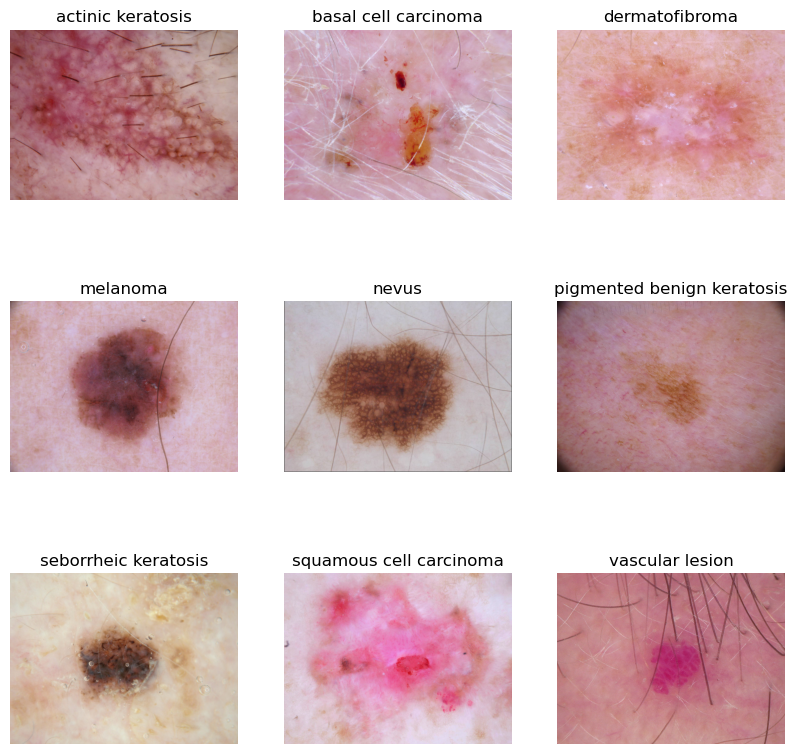

In [11]:
plt.figure(figsize=(10,10))

for lesion_type in range(class_number):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img=PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### creating CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. 

In [13]:
### Your code goes here
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### choosing adam- appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 158s 727ms/step - loss: 1.8221 - accuracy: 0.3208 - val_loss: 2.1136 - val_accuracy: 0.3478
Epoch 2/20
169/169 [==============================] - 117s 690ms/step - loss: 1.4784 - accuracy: 0.4453 - val_loss: 2.0584 - val_accuracy: 0.2609
Epoch 3/20
169/169 [==============================] - 125s 740ms/step - loss: 1.2608 - accuracy: 0.5360 - val_loss: 2.3868 - val_accuracy: 0.1739
Epoch 4/20
169/169 [==============================] - 114s 675ms/step - loss: 1.1457 - accuracy: 0.5772 - val_loss: 2.7092 - val_accuracy: 0.2609
Epoch 5/20
169/169 [==============================] - 107s 636ms/step - loss: 0.9610 - accuracy: 0.6545 - val_loss: 2.5935 - val_accuracy: 0.1739
Epoch 6/20
169/169 [==============================] - 107s 636ms/step - loss: 0.8557 - accuracy: 0.6901 - val_loss: 3.9118 - val_accuracy: 0.2609
Epoch 7/20
169/169 [==============================] - 129s 763ms/step - loss: 0.7026 - accuracy: 0.7485 - val_loss: 3.8693 -

### Visualizing training results

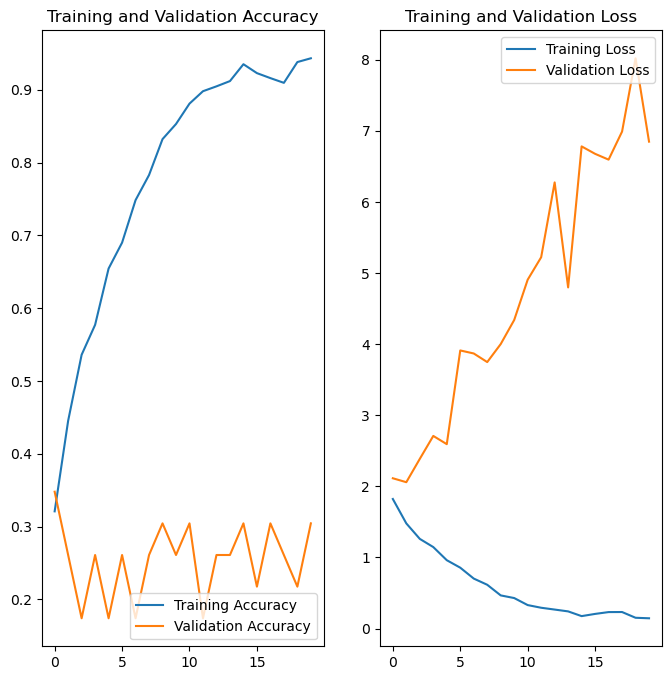

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
There is clearly evidence of overfitting, with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

In [18]:
# Choosing an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3),
    keras_cv.layers.RandomColorDegeneration(0.5)
])

In [19]:
# Configuring the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
cached_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cached_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

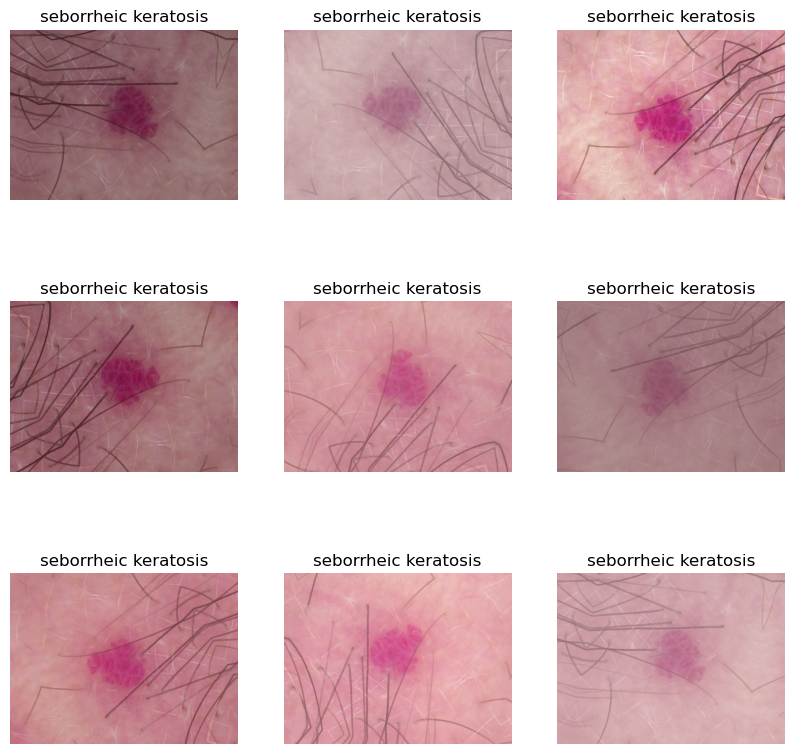

In [20]:
# visualizng augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))

for images, labels in cached_train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    plt.axis("off")


### Data augmentation and dropout layers


In [21]:
## Use Dropout layer if there is an evidence of overfitting 
dropout_conv=0.05
dropout_dense=0.25

model_aug_drop = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),  
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes)
])


### Compiling the model

In [22]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
epochs = 20 # As specified in the project pipeline
history = model_aug_drop.fit(
  cached_train_ds,
  validation_data = cached_val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 165s 957ms/step - loss: 2.1110 - accuracy: 0.1884 - val_loss: 2.2719 - val_accuracy: 0.0870
Epoch 2/20
169/169 [==============================] - 168s 990ms/step - loss: 1.8805 - accuracy: 0.2838 - val_loss: 2.2644 - val_accuracy: 0.3043
Epoch 3/20
169/169 [==============================] - 177s 1s/step - loss: 1.7584 - accuracy: 0.3336 - val_loss: 2.1237 - val_accuracy: 0.3043
Epoch 4/20
169/169 [==============================] - 157s 928ms/step - loss: 1.7329 - accuracy: 0.3416 - val_loss: 2.3241 - val_accuracy: 0.2609
Epoch 5/20
169/169 [==============================] - 157s 928ms/step - loss: 1.6464 - accuracy: 0.3754 - val_loss: 2.2187 - val_accuracy: 0.3043
Epoch 6/20
169/169 [==============================] - 154s 912ms/step - loss: 1.6555 - accuracy: 0.3741 - val_loss: 2.2211 - val_accuracy: 0.2609
Epoch 7/20
169/169 [==============================] - 147s 867ms/step - loss: 1.6087 - accuracy: 0.3843 - val_loss: 2.0163 - va

### Visualizing the results

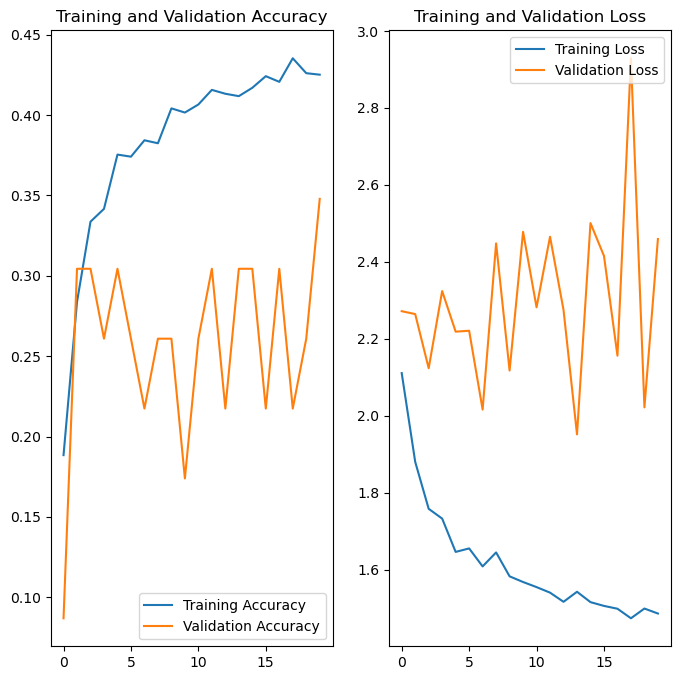

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations of modified model
As can be seen, the model with augmentation layers and dropouts does not perform better on the training data, actually performing significantly worse. The model still performs poorly during inference using the validation set. There is some improvement, but the model is still overfitting.

In [25]:
##Using seed=123 while creating  dataset using tf.keras.preprocessing.image_dataset_from_directory
## resize your images to the size img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Display of the number of samples for each class/label¶

In [26]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

actinic keratosis             493
basal cell carcinoma          721
dermatofibroma                455
melanoma                      755
nevus                         677
pigmented benign keratosis    773
seborrheic keratosis          456
squamous cell carcinoma       569
vascular lesion               493
dtype: int64


#### Class vs Samples data

#### - Which class has the least number of samples?
seborrheic keratosis  has has the least number of samples                
#### - Which classes dominate the data in terms proportionate number of samples?
The classes with the most samples are: pigmented benign keratosis 370 melanoma 352 basal cell carcinoma 309 nevus 277 Clearly the classes "pigmented benign keratosis" and "melanoma" dominate the data.

#### Rectify the class imbalance


In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x10E2838F430>: 100%|█| 500/500 [00:05<00:


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x10E283E8550>: 100%|█| 500/500 [00:05<00:00, 89.84 Samples/


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x10E2A0CB310>: 100%|█| 500/500 [00:05<00:00, 84.68 Samples/


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x10E25D3DB10>: 100%|█| 500/500 [00:33<00:00, 15.03 Samples


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x10E292F7250>: 100%|█| 500/500 [00:30<00:00, 16.35 Samples


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x10E2A092200>: 100%|█| 500/500 [00:03<00:00, 127.85 Samples


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x10E25C87250>: 100%|█| 500/500 [00:13<00:00, 38.24 Samples


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x10E0A0DA620>: 100%|█| 500/500 [00:04<00:00, 101.41 Samples


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x10E25D3EB90>: 100%|█| 500/500 [00:06<00:00, 81.90 Samples/


In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


#### Train the model on the data created using Augmentor

In [30]:
batch_size = 32
img_height = 180
img_width = 180

 Create a training dataset

In [31]:
data_dir_train = pathlib.Path('./Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


 Create a validation dataset

In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Create your model (make sure to include normalization)

In [33]:
num_classes = 9

model3 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

####  Compile your model (Choose optimizer and loss function appropriately)

In [34]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [35]:
epochs = 30

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 606s 2s/step - loss: 1.6567 - accuracy: 0.3662 - val_loss: 1.3924 - val_accuracy: 0.4566
Epoch 2/30
281/281 [==============================] - 598s 2s/step - loss: 1.2238 - accuracy: 0.5356 - val_loss: 1.0859 - val_accuracy: 0.5964
Epoch 3/30
281/281 [==============================] - 595s 2s/step - loss: 0.9027 - accuracy: 0.6772 - val_loss: 0.8978 - val_accuracy: 0.6747
Epoch 4/30
281/281 [==============================] - 592s 2s/step - loss: 0.6449 - accuracy: 0.7766 - val_loss: 0.8771 - val_accuracy: 0.7116
Epoch 5/30
281/281 [==============================] - 611s 2s/step - loss: 0.4715 - accuracy: 0.8346 - val_loss: 0.6178 - val_accuracy: 0.7864
Epoch 6/30
281/281 [==============================] - 541s 2s/step - loss: 0.3350 - accuracy: 0.8865 - val_loss: 0.5014 - val_accuracy: 0.8398
Epoch 7/30
281/281 [==============================] - 451s 2s/step - loss: 0.2630 - accuracy: 0.9098 - val_loss: 0.5580 - val_accuracy: 0.8336

#### **Todo:**  Visualize the model results

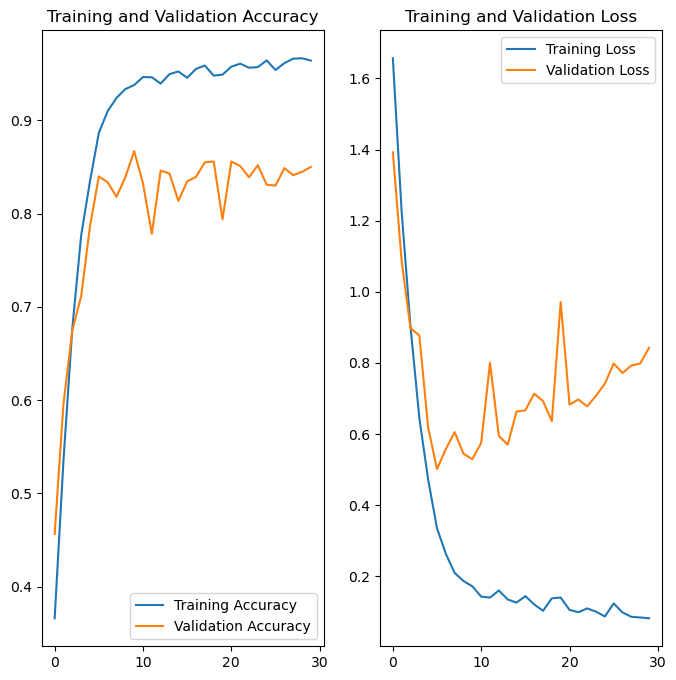

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  The model created with augmenter has an accuracy of 0.9640 at 30 epochs and a loss of 0.8. The model with augmented the data and countering class imbalance  predict the class of the lesion with a high accuracy.The data augmentation and countering class imbalance improved the accuracy of the model.

